# Bloqueo del haz

Este cuaderno mostrará las zonas en las cuales el haz del radar es bloqueado por algún obstáculo del relieve topográfico. Como tal este cuaderno no es más que una adaptación del cuaderno de Wradlib para calcular el bloqueo del haz, sólo que posee los datos de Piura en su lugar.

In [6]:
import wradlib as wrl
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# Filtramos las advertencias
import warnings
warnings.filterwarnings('ignore')

Necesitamos datos acerca de la posición geográfica del radar así como de algunas de sus características.

In [7]:
sitecoords = (-80.63895, -5.17044, 56)
nrays = 360 # Número de rayos
nbins = 1000 # Número de divisiones del rango
el = 2.0 # Angulo de elevación vertical de la antena (deg)
bw = 1.0 # Medio ancho del angulo de barrido (deg)
range_res = 100. # Resolución del rango (meters)

Con ellos construimos el vector de distancias(que corresponde al r ya visto en los módulos, solo que en metros.)

In [8]:
r = np.arange(nbins) * range_res

Necesitamos calcular el "radio de potencia media". Este corresponde a una función de utilidad derivada de la librería PyRadarMet.

<img src=ecuation.jpg >

Si necesitas más información al respecto puedes consultar la librería tu mismo.

In [22]:
beamradius = wrl.util.half_power_radius(r, bw)

Cambiamos los datos hacia el punto central de cada grilla.

In [11]:
coord = wrl.georef.sweep_centroids(nrays, range_res, nbins, el)


In [9]:
help(wrl.georef.sweep_centroids)

Help on function sweep_centroids in module wradlib.georef.polar:

sweep_centroids(nrays, rscale, nbins, elangle)
    Construct sweep centroids native coordinates.
    
    Parameters
    ----------
    nrays : int
        number of rays
    rscale : float
        length [m] of a range bin
    nbins : int
        number of range bins
    elangle : float
        elevation angle [radians]
    
    Returns
    -------
    coordinates : 3d array
        array of shape (nrays,nbins,3) containing native centroid radar
        coordinates (slant range, azimuth, elevation)



A pesar de lo que dice la documentación, el ángulo de elevación no debe estar en radianes sino en grados sexagesimales (deg).

Proyectamos los datos a la malla cartesiana y sobre el objeto OSR predeterminado(proyección WSG 84).

In [12]:
coords = wrl.georef.spherical_to_proj(coord[..., 0], np.degrees(coord[..., 1]),
                                      coord[..., 2], sitecoords)

Desdoblamos los datos en sus componentes(longitud, latitud y altitud).

In [15]:
lon = coords[..., 0]
lat = coords[..., 1]
alt = coords[..., 2]

Vemos sus dimensiones.

In [16]:
polcoords = coords[...,:2]
print("lon,lat,alt:", coords.shape)

lon,lat,alt: (360, 1000, 3)


Definimos los límites de trabajo, esto permitirá aliviar la carga computacional si se usa un DEM más grande que el alcance del radara. 

In [17]:
rlimits = (lon.min(),lat.min(),lon.max(),lat.max())
print("\nValores delimitadores del radar:")
print('\t{:.5}'.format(lat.max()))
print('{:.5}\t\t{:.5}'.format(lon.min(),lon.max()))
print('\t{:.5}'.format(lat.min()))


Valores delimitadores del radar:
	-4.2676
-81.539		-79.738
	-6.0733


Obviamente los límites definen un rectángulo y no un rombo(por si las moscas).

Abrimos el archivo ráster donde se encuentra la información geográfica o el Modelo de Elevación Digital (DEM).

In [18]:
ds = wrl.io.gdal.open_raster('C:/Users/Elmer Lopez Ramirez/Downloads/RadarPiuraDEM.tif')
rastervalues, rastercoords, proj = wrl.georef.extract_raster_dataset(ds, nodata=-32768.)

Recortamos la región de interés (ROI)

In [19]:
ind = wrl.util.find_bbox_indices(rastercoords, rlimits)
rastercoords = rastercoords[ind[1]:ind[3], ind[0]:ind[2], ...]
rastervalues = rastervalues[ind[1]:ind[3], ind[0]:ind[2]]

Ajustamos los valores de las grillas a través de una spline. 

In [20]:
polarvalues = wrl.ipol.cart_to_irregular_spline(rastercoords, rastervalues, polcoords, order=3, prefilter=False)

Calculamos el PBB de cada celda (Portion Beam Blockage)

In [23]:
PBB = wrl.qual.beam_block_frac(polarvalues, alt, beamradius)
PBB = np.ma.masked_invalid(PBB)

Y dado que cada fracción no puede ser menor que la anterior en un mismo rayo, calculamos el "Acumulativo"(que propiamente no lo es).

In [24]:
CBB = wrl.qual.cum_beam_block_frac(PBB)

Con eso técnicamente hemos terminado, en adelante sólo queda graficar los resultados. Si no entiendes las líneas de código, no te preocupes tanto. Nos ayudaremos de algunas funciones. 

In [28]:
def annotate_map(ax, cm=None, title=""):
    ticks = (ax.get_xticks()/1000).astype(np.int)
    ax.set_xticklabels(ticks)
    ticks = (ax.get_yticks()/1000).astype(np.int)
    ax.set_yticklabels(ticks)
    ax.set_xlabel("Kilómetros")
    ax.set_ylabel("Kilómetros")
    if not cm is None:
        plt.colorbar(cm, ax=ax)
    if not title=="":
        ax.set_title(title)
    ax.grid()

También se realizará la gráfica del perfil vertical a lo largo de un rayo del radar. Escogeremos un valor de 70°. Toma en cuenta que este se mide desde la dirección Norte con sentido antihorario. Eres libre de cambiarlo para ver que sucede en otros
ángulos. 

In [26]:
angle = 70

Explicaré los pasos poco a poco por si no estas acostumbrado a las funciones de **`matplotlib`**

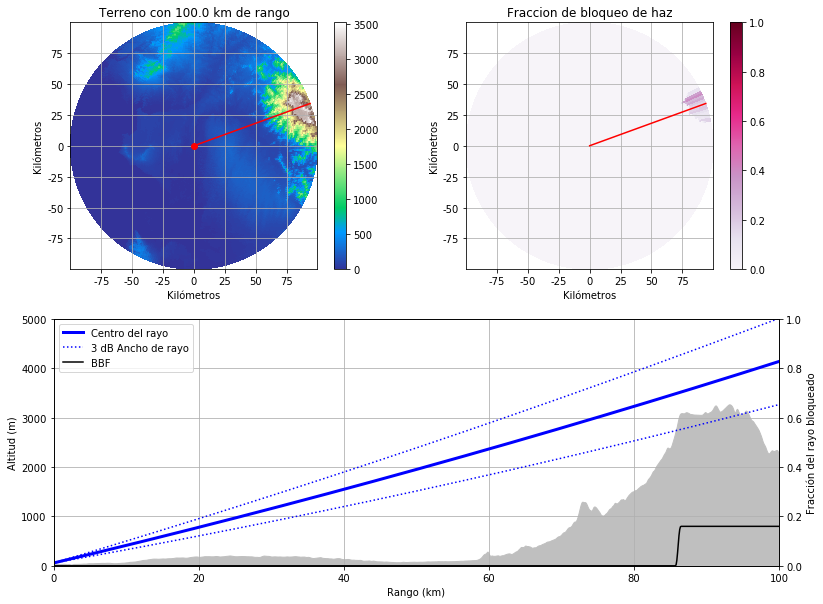

In [39]:
# Figura
fig = plt.figure(figsize=(13, 10))

# Agregamos las sub-gráficas
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2, rowspan=1)

# Información del DEM en la primera cuadricula 
ax1, dem = wrl.vis.plot_ppi(polarvalues,ax=ax1, r=r, az=np.degrees(coord[:,0,1]), cmap=mpl.cm.terrain, vmin=0.)
ax1.plot([0,np.sin(np.radians(angle))*1e5], [0,np.cos(np.radians(angle))*1e5],"r-")
ax1.plot(sitecoords[0], sitecoords[1], 'ro')
annotate_map(ax1, dem, 'Terreno con {0} km de rango'.format(np.max(r / 1000.) + 0.1))

# Resultados del CBB
ax2, cbb = wrl.vis.plot_ppi(CBB, ax=ax2, r=r, az=np.degrees(coord[:,0,1]), cmap=mpl.cm.PuRd, vmin=0, vmax=1)
ax2.plot([0,np.sin(np.radians(angle))*1e5], [0,np.cos(np.radians(angle))*1e5],"r-")
ax2.plot(sitecoords[0], sitecoords[1], 'ro')
annotate_map(ax2, cbb, 'Fraccion de bloqueo de haz')

# Mostramos uno de los rayos del radar 
bc, = ax3.plot(r / 1000., alt[angle, :], '-b', linewidth=3, label='Centro del rayo(azi = {})'.format(angle))
b3db, = ax3.plot(r / 1000., (alt[angle, :] + beamradius), ':b', linewidth=1.5, label='3 dB Ancho del rayo')
ax3.plot(r / 1000., (alt[angle, :] - beamradius), ':b')
ax3.fill_between(r / 1000., 0., polarvalues[angle, :], color='0.75')
ax3.set_xlim(0., np.max(r / 1000.) + 0.1)
ax3.set_ylim(0., 5000)
ax3.set_xlabel('Rango (km)')
ax3.set_ylabel('Altitud (m)')
ax3.grid()

axb = ax3.twinx()
bbf, = axb.plot(r / 1000., CBB[angle, :], '-k', label='BBF')
axb.set_ylabel('Fracción del rayo bloqueado')
axb.set_ylim(0., 1.)
axb.set_xlim(0., np.max(r / 1000.) + 0.1)
legend = ax3.legend((bc, b3db, bbf), ('Centro del rayo', '3 dB Ancho de rayo', 'BBF'), loc='upper left', fontsize=10)

El resto del código es sólo para una "gráfica fancy" que involucra colocar los datos viendo la curvatura de la tierra. 

Para ello nos ayudaremos de dos funciones pequeñas. 

In [42]:
def height_formatter(x, pos):
    x = (x - 6370000) / 1000
    fmt_str = '{:g}'.format(x)
    return fmt_str

def range_formatter(x, pos):
    x = x / 1000.
    fmt_str = '{:g}'.format(x)
    return fmt_str

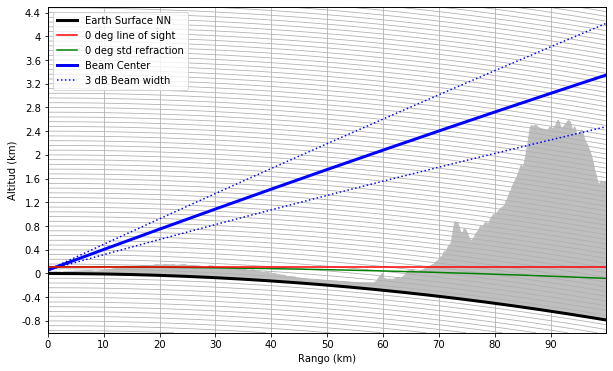

In [43]:
#Creamos la figura
fig = plt.figure(figsize=(10, 6))
cgax, caax, paax = wrl.vis.create_cg(fig=fig, rot=0, scale=1)

# Arreglamos el creador de la grilla
er = 6370000
gh = cgax.get_grid_helper()
gh.grid_finder.grid_locator2._nbins=80
gh.grid_finder.grid_locator2._steps=[1,2,4,5,10]

# Se calcula  la altura del rayo y su distancia de arco for ke=1(esto se agrega considerando ecp. El valor pred es 4/3)
bhe = wrl.georef.bin_altitude(r, 0, sitecoords[2], re=er, ke=1.)
ade = wrl.georef.bin_distance(r, 0, sitecoords[2], re=er, ke=1.)
nn0 = np.zeros_like(r)

# Para una gráfica fácil se asume earth_radius = 6370000 m
ecp = nn0 + er

# theta (arc_distance sector angle)
thetap = - np.degrees(ade/er) + 90.0

# Elevación a cero grados usando la refracción estandar.
bh0 = wrl.georef.bin_altitude(r, 0, sitecoords[2], re=er)

# Mostramos el resultado 
bes, = paax.plot(thetap, ecp, '-k', linewidth=3, label='Earth Surface NN')
bc, = paax.plot(thetap, ecp + alt[angle, :], '-b', linewidth=3, label='Beam Center')
bc0r, = paax.plot(thetap, ecp + bh0 + alt[angle, 0] , '-g', label='0 deg Refraction')
bc0n, = paax.plot(thetap, ecp + bhe + alt[angle, 0], '-r', label='0 deg line of sight')
b3db, = paax.plot(thetap, ecp + alt[angle, :]  + beamradius, ':b', label='+3 dB Beam width')
paax.plot(thetap, ecp + alt[angle, :] - beamradius, ':b', label='-3 dB Beam width')

# Agregamos el dibujito de las montañas
paax.fill_between(thetap, ecp, ecp + polarvalues[angle, :], color='0.75')

# Fancy ejes
cgax.set_xlim(0, np.max(ade))
cgax.set_ylim([ecp.min()-1000, ecp.max()+4500])
caax.grid(True, axis='x')
cgax.grid(True, axis='y')
cgax.axis['top'].toggle(all=False)
caax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(steps=[1,2,4,5,10], nbins=20, prune='both'))
caax.xaxis.set_major_locator(mpl.ticker.MaxNLocator())
caax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(height_formatter))
caax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(range_formatter))

caax.set_xlabel('Rango (km)')
caax.set_ylabel('Altitud (km)')

legend = paax.legend((bes, bc0n, bc0r, bc, b3db),
                    ('Earth Surface NN', '0 deg line of sight', '0 deg std refraction', 'Beam Center', '3 dB Beam width'),
                    loc='upper left', fontsize=10)


Es conveniente analizar los resultados para comprobar que sucede si variamos el ángulo de elevación de la antena. De ser posible encontrar una montaña que se marque como clutter en el radar, esto nos sería muy útil para comprobar la atenuación que sufre la señal bajo condiciones de precipitación. 